In [1]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 3.2 MB/s 


In [2]:
from sklearn.datasets import load_diabetes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X, y = load_diabetes(return_X_y=True, as_frame=True)

In [3]:
X.describe()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


In [5]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate

from pygam import LinearGAM
import warnings
warnings.filterwarnings('ignore')

gam = LinearGAM().fit(X, y)
gam.summary()

pred = gam.predict(X)
print("R2 Train  =", r2_score(y,pred))
print("MSE Train =", mean_squared_error(y,pred))


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     92.0369
Link Function:                     IdentityLink Log Likelihood:                                 -3893.2146
Number of Samples:                          442 AIC:                                             7972.5028
                                                AICc:                                            8022.7891
                                                GCV:                                             4208.5528
                                                Scale:                                           2668.0171
                                                Pseudo R-Squared:                                   0.6438
Feature Function                  Lam

In [6]:
def validacaoCruzada(model, X, y, use_sm=False):
  kf = KFold(n_splits=5, shuffle=True, random_state=20)
  mse_cv = []
  r2_cv  = []

  for train_idx, vali_idx in kf.split(X):  
    if use_sm:
       model = sm.OLS(y[train_idx], X.iloc[train_idx]).fit() 
    else:
      model.fit(X.iloc[train_idx], y[train_idx])
    pred = model.predict(X.iloc[vali_idx])
    mse_cv.append( mean_squared_error(y[vali_idx], pred) )
    r2_cv.append( r2_score(y[vali_idx], pred) )
  
  return np.mean(mse_cv), np.mean(r2_cv)

In [7]:
from pygam import LinearGAM, s, f
import warnings
warnings.filterwarnings('ignore')

gam = LinearGAM().fit(X, y)
gam.summary()

cv_mse, cv_r2 = validacaoCruzada(gam, X, y)
print("R2  CV    =", cv_r2  )
print("MSE CV    =", cv_mse )





LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     92.0369
Link Function:                     IdentityLink Log Likelihood:                                 -3893.2146
Number of Samples:                          442 AIC:                                             7972.5028
                                                AICc:                                            8022.7891
                                                GCV:                                             4208.5528
                                                Scale:                                           2668.0171
                                                Pseudo R-Squared:                                   0.6438
Feature Function                  Lam

In [8]:
import statsmodels.api as sm

Xs = sm.add_constant(X)
results = sm.OLS(y, Xs).fit()
print(results.summary())

pred = results.predict(Xs)
print("R2 Train  =", r2_score(y,pred))
print("MSE Train =", mean_squared_error(y,pred))

cv_mse, cv_r2 = validacaoCruzada(results, Xs, y, use_sm=True)
print("R2  CV    =", cv_r2  )
print("MSE CV    =", cv_mse )

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           3.83e-62
Time:                        17:20:09   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

In [9]:
lam = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

for l in lam:
  gam = LinearGAM(lam=l).fit(X, y)

  print("------- l =", l, "-------")
  pred = gam.predict(X)
  print("R2 Train  =", r2_score(y,pred))
  print("MSE Train =", mean_squared_error(y,pred))

  cv_mse, cv_r2 = validacaoCruzada(gam, X, y)
  print("R2  CV    =", cv_r2  )
  print("MSE CV    =", cv_mse )


------- l = 0 -------
R2 Train  = 0.715997946834437
MSE Train = 1684.099485758012
R2  CV    = -507.36790724110443
MSE CV    = 3036340.1198970214
------- l = 0.001 -------
R2 Train  = 0.7079979344778351
MSE Train = 1731.5386382065217
R2  CV    = -1.1788281549415331
MSE CV    = 13213.682146131576
------- l = 0.01 -------
R2 Train  = 0.7008104150667502
MSE Train = 1774.159801008564
R2  CV    = -1.255938403634097
MSE CV    = 14013.993543975195
------- l = 0.1 -------
R2 Train  = 0.6763676786020809
MSE Train = 1919.1024148095676
R2  CV    = 0.08252834576178278
MSE CV    = 5552.192996524952
------- l = 1 -------
R2 Train  = 0.6339525003677392
MSE Train = 2170.619539621152
R2  CV    = 0.43342835160671045
MSE CV    = 3341.1377068962347
------- l = 10 -------
R2 Train  = 0.5948789656423314
MSE Train = 2402.321103058251
R2  CV    = 0.4799557218915673
MSE CV    = 3064.7776644934675
------- l = 100 -------
R2 Train  = 0.565791060722155
MSE Train = 2574.8090311271703
R2  CV    = 0.4982701524232104


In [10]:
lam = [250, 500, 750, 1000, 1250, 1500, 2000]

for l in lam:
  gam = LinearGAM(lam=l).fit(X, y)

  print("------- l =", l, "-------")
#  pred = gam.predict(X)
#  print("R2 Train  =", r2_score(y,pred))
#  print("MSE Train =", mean_squared_error(y,pred))

  cv_mse, cv_r2 = validacaoCruzada(gam, X, y)
  print("R2  CV    =", cv_r2  )
  print("MSE CV    =", cv_mse )

------- l = 250 -------
R2  CV    = 0.5014265426014841
MSE CV    = 2936.483690655924
------- l = 500 -------
R2  CV    = 0.5017411222962195
MSE CV    = 2933.1477792154583
------- l = 750 -------
R2  CV    = 0.5009973403320958
MSE CV    = 2936.668661629119
------- l = 1000 -------
R2  CV    = 0.5000525191930031
MSE CV    = 2941.6407594164784
------- l = 1250 -------
R2  CV    = 0.4990947863617287
MSE CV    = 2946.8349658739107
------- l = 1500 -------
R2  CV    = 0.49818063126314716
MSE CV    = 2951.864395630961
------- l = 2000 -------
R2  CV    = 0.49653838062467903
MSE CV    = 2960.9997890502614


In [12]:
am = LinearGAM(lam=500).fit(X, y)
am.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.8927
Link Function:                     IdentityLink Log Likelihood:                                 -3914.9065
Number of Samples:                          442 AIC:                                             7875.5984
                                                AICc:                                            7878.2149
                                                GCV:                                             3075.0504
                                                Scale:                                           2802.1617
                                                Pseudo R-Squared:                                   0.5509
Feature Function                  Lam

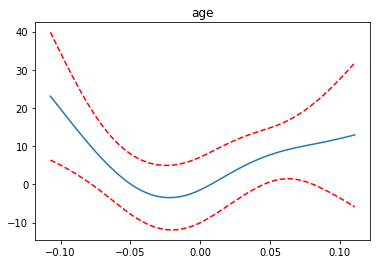

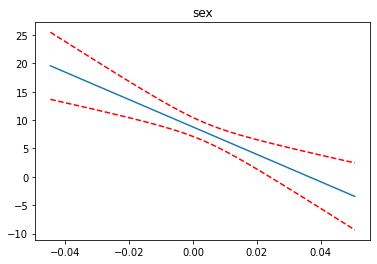

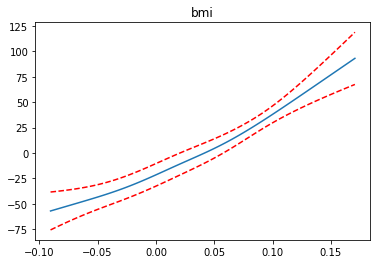

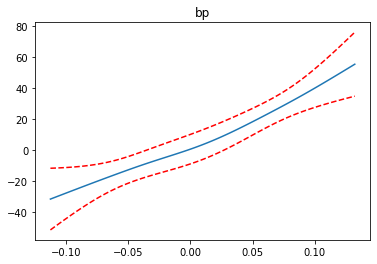

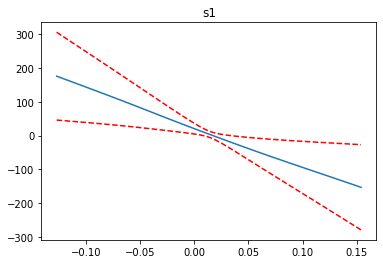

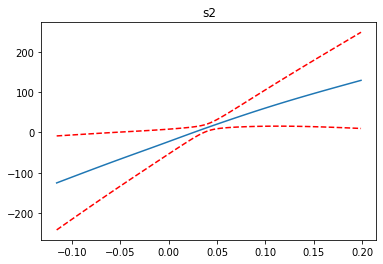

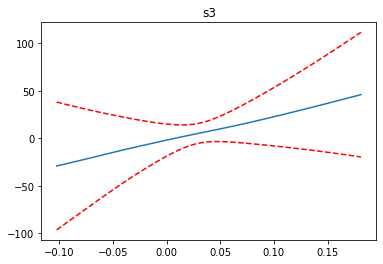

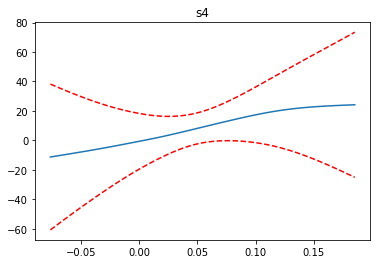

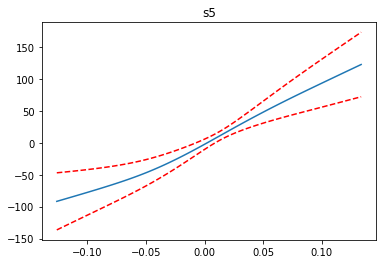

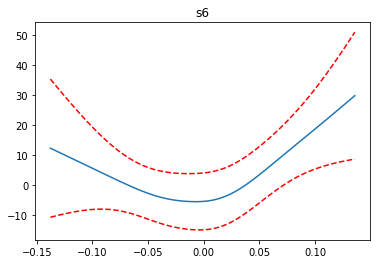

In [13]:
gam = LinearGAM(lam=500).fit(X, y)
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue    
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns[i])
    plt.show()